<a href="https://colab.research.google.com/github/plaban1981/TOPIC_Modeling_NLP/blob/main/Google_App_Review_Classification_Using_Weighted_Class_Based_Tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Exploration
We'll load the Google Play app reviews dataset:


## Hypothesis : 

            In imbalanced class scenarios, when we use normal tfidf or countvect majority class words takes preference.
            Since this class overpowers all other classes, the words associated with the majority class are majorly choosen in the vocab. 
            So the words associated with minority classes are not present in the vocab and that hinders the model's
            ability to classify examples belonging to other classes.
             


In [1]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 47.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 43.8MB/s]


In [3]:
!pip install -q texthero

     |████████████████████████████████| 1.5 MB 18.4 MB/s 
     |████████████████████████████████| 235 kB 97.1 MB/s 
     |████████████████████████████████| 749 kB 88.2 MB/s 


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#
import texthero as hero
#
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
#
import warnings
warnings.filterwarnings('ignore')
#
%matplotlib inline

In [5]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


## Data description

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


## Missing Values

In [7]:
df.isnull().sum()[df.isnull().sum() > 0]

reviewCreatedVersion    2213
replyContent            8379
repliedAt               8379
dtype: int64

* no missing values in the score and review texts!

## Check for Class Imbalance

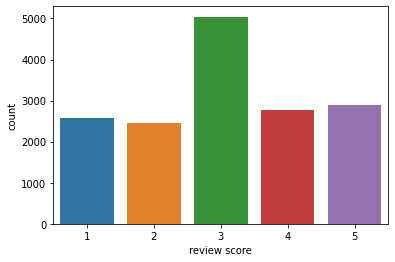

In [9]:
sns.countplot(x='score',data=df)
plt.xlabel('review score')
plt.show()

* Data is imbalanced We're going to convert the dataset into negative(0),  positive sentiment(1):

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  else: 
    return 1

df['sentiment'] = df.score.apply(to_sentiment)

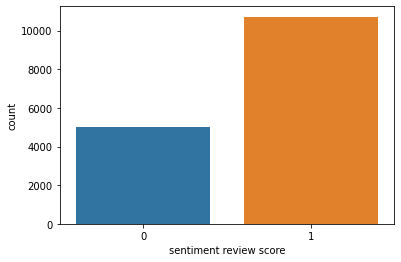

In [13]:
sns.countplot(x='sentiment',data=df)
plt.xlabel('sentiment review score')
plt.show()

In [14]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


In [15]:
df['clean_content'] = hero.clean(df['content'])

In [17]:
df[['content','clean_content','sentiment']].head()

,content,clean_content,sentiment
0,Update: After getting a response from the deve...,update getting response developer would change...,0
1,Used it for a fair amount of time without any ...,used fair amount time without problems suddenl...,0
2,Your app sucks now!!!!! Used to be good but no...,app sucks used good update physically open clo...,0
3,"It seems OK, but very basic. Recurring tasks n...",seems ok basic recurring tasks need work actua...,0
4,Absolutely worthless. This app runs a prohibit...,absolutely worthless app runs prohibitively cl...,0


In [18]:
print(df.shape)
df = df[['clean_content','sentiment']]
print(df.shape)

(15746, 13)
(15746, 2)


In [27]:
df.sentiment.value_counts()

1    10718
0     5028
Name: sentiment, dtype: int64

In [37]:
 label_dict = df.sentiment.value_counts(normalize=True).to_dict()
 label_dict

{0: 0.3193191921757907, 1: 0.6806808078242094}

In [38]:
for key,val in label_dict.items():
            new_val = int(np.round(val,1)* 1000)
            label_dict[key] = new_val

In [39]:
label_dict

{0: 300, 1: 700}

In [59]:
class Wcbtfidf:
    
    def __init__(self,max_features):
        self.max_features = max_features
        self.combine_vocab = []
        self.final_tfidf = None
    
    def fit(self,X,y):
        
        label_dict = y.value_counts(normalize=True).to_dict()
        for key,val in label_dict.items():
            new_val = int(np.round(val,1)*self.max_features)
            label_dict[key] = new_val
        
        self.combine_vocab = self.return_total_vocab(X,y,label_dict)
        self.final_tfidf = TfidfVectorizer(vocabulary=self.combine_vocab,stop_words='english')
        self.final_tfidf.fit(X)
    
    def transform(self,X):
        transformed_data = self.final_tfidf.transform(X)
        transformed_data = pd.DataFrame(transformed_data.toarray(),columns=self.combine_vocab)
        return transformed_data
    
    def return_total_vocab(self,X,y,label_dict):

        exclude = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
                 "you", "your", "yours", "yourself", "yourselves", "he", "him", 
                 "his", "himself", "she", "her", "hers", "herself", "it", "its", 
                 "itself", "they", "them", "their", "theirs", "themselves", "what", 
                 "which", "who", "whom", "this", "that", "these", "those", "am", "is", 
                 "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", 
                 "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", 
                 "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", 
                 "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", 
                 "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", 
                 "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", 
                 "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", 
                 "just", "don", "should", "now"]

        total_vocab = []
        ## will return keywords from respecvtive classes which can be fed as vocabulary to tfidf
        for key,val in label_dict.items():
            slice_data = X[y==key]
            tfidf = TfidfVectorizer(max_features=val,stop_words=exclude)
            tfidf.fit(slice_data)
            vocab = tfidf.vocabulary_
            total_vocab.extend(vocab)
            exclude.extend(vocab)
            #print(exclude)
        
        return total_vocab

In [54]:
xtrain,xtest,ytrain,ytest = train_test_split(df['clean_content'],df['sentiment'],test_size=0.25,random_state=60)

print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

(11809,) (11809,)
(3937,) (3937,)


In [55]:
def check_hypothesis(xtrain,xtest,ytrain,ytest,max_feat,model):
    
    print('Running base version')
    tfidf = TfidfVectorizer(max_features=max_feat,stop_words='english')
    train_df = pd.DataFrame(tfidf.fit_transform(xtrain).toarray(),columns=tfidf.vocabulary_)
    test_df = pd.DataFrame(tfidf.transform(xtest).toarray(),columns=tfidf.vocabulary_)
    
    
    model.fit(train_df,ytrain)
    preds = model.predict(test_df)
    print(f'Precision is {precision_score(ytest,preds)}')
    print(f'Recall is {recall_score(ytest,preds)}')
    print(f'ROC curve is {roc_auc_score(ytest,preds)}')
    print(classification_report(ytest,preds))
    
    print('Running my version')
    wcbtfidf = Wcbtfidf(max_features=max_feat)
    wcbtfidf.fit(xtrain,ytrain)    
    train_df = wcbtfidf.transform(xtrain)
    test_df = wcbtfidf.transform(xtest)
    
    model.fit(train_df,ytrain)
    preds = model.predict(test_df)
    print(f'Precision is {precision_score(ytest,preds)}')
    print(f'Recall is {recall_score(ytest,preds)}')
    print(f'ROC curve is {roc_auc_score(ytest,preds)}')
    print(classification_report(ytest,preds))

In [60]:
model = LogisticRegression()
check_hypothesis(xtrain,xtest,ytrain,ytest,400,model)

Running base version
Precision is 0.7861656135683406
Recall is 0.8814317673378076
ROC curve is 0.684540584864123
              precision    recall  f1-score   support

           0       0.66      0.49      0.56      1255
           1       0.79      0.88      0.83      2682

    accuracy                           0.76      3937
   macro avg       0.72      0.68      0.70      3937
weighted avg       0.75      0.76      0.74      3937

Running my version
Precision is 0.7938420348058902
Recall is 0.8844146159582401
ROC curve is 0.6967889812858931
              precision    recall  f1-score   support

           0       0.67      0.51      0.58      1255
           1       0.79      0.88      0.84      2682

    accuracy                           0.76      3937
   macro avg       0.73      0.70      0.71      3937
weighted avg       0.76      0.76      0.75      3937

